## Imports

In [68]:
# imports
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time
import pickle

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
from IPython.display import clear_output
from collections import defaultdict
import math
import matplotlib.pyplot as plt

%matplotlib inline

## Utility functions
### Load Filenames
`load_filenames` loads all filenames in a directory and all supdirectories.

In [69]:
def load_filenames(directory):
    filenames = []

    # os.walk yields a 3-tuple: (current_path, directories, files)
    for root, dirs, files in os.walk(directory):
        for filename in files:
            # Join the 'root' (current folder being visited) with the filename
            file_path = os.path.join(root, filename)
            filenames.append(file_path)

    return filenames

### Spectrogram

In [70]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

### Constellation map

In [71]:
from concurrent.futures import ThreadPoolExecutor


def compute_constellation_map(Y, dist_freq=4, dist_time=4, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap


def compute_constellation_map_single(args):
    """Compute the constellation map for a single file."""
    filename, dist_freq, dist_time = args
    spectrogram = compute_spectrogram(filename)  # Perform I/O and computation
    constellation_map = compute_constellation_map(spectrogram, dist_freq, dist_time)
    return filename, constellation_map


def compute_constellation_maps(filenames, dist_freq, dist_time):
    """Compute constellation maps using multithreading."""
    # Prepare arguments for each file
    args = [(filename, dist_freq, dist_time) for filename in filenames]

    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor() as executor:
        results = executor.map(compute_constellation_map_single, args)

    # Convert results to a dictionary
    Cmaps = dict(results)
    return Cmaps

In [72]:
count = 0
count2 = 0
hash_count = {}

## Computing hashes for a single audio track

In [73]:
import gc

def compute_hashes_from_spectrogram(filename, dist_freq=4,
                                    dist_time=4,
                                    time_min_offset=0, time_max_offset=25,
                                    freq_min_offset=-15,
                                    freq_max_offset=15
                                   ):
    """
    Compute hashes for a single track directly from its spectrogram.

    Args:
        filename (str): Path to the audio file.
        dist_freq (int): Neighborhood parameter for frequency direction.
        dist_time (int): Neighborhood parameter for time direction.
        time_min_offset, time_max_offset, freq_min_offset, freq_max_offset (int):
            Bounds for the "target zone" around an anchor point.

    Returns:
        list: [(hash, track_name, time_offset), ...]
    """

    global count
    global count2
    spectrogram = compute_spectrogram(filename)
    cmap = compute_constellation_map(spectrogram, dist_freq, dist_time)

    # Convert the boolean map to a list of points (freq, time), sorted by time
    point_list = sorted(np.argwhere(cmap).tolist(), key=lambda x: x[1])
    hashes = []
    del cmap
    del spectrogram

    for anchor in point_list:
        target_points = get_target_zone_points(
            anchor,
            point_list,
            time_min_offset=time_min_offset,
            time_max_offset=time_max_offset,
            freq_min_offset=freq_min_offset,
            freq_max_offset=freq_max_offset
        )
        for target_point in target_points:
            h = compute_hash(anchor, target_point)
            hashes.append((h, int(extract_numeric_id(filename)), anchor[1]))

    count += 1
    count2 += 1
    if (count % 1000) == 0:
        gc.collect()
        print(f"Processed {count} tracks")

    return hashes

## Building our database

In [74]:
def build_database(directory, dist_freq=4, dist_time=4,
    time_min_offset=0, time_max_offset=25,
    freq_min_offset=-15, freq_max_offset=15):
    """
    Build a fingerprint database directly from spectrograms using multithreading.

    Args:
        directory (str): Directory containing audio files.
        dist_freq, dist_time (int): Constellation map neighborhood parameters.
        time_min_offset, time_max_offset, freq_min_offset, freq_max_offset (int):
            Bounds for the "target zone" around an anchor point.

    Returns:
        database (defaultdict): {hash: [(track_name, time_offset), ...]}
    """
    global count
    count = 0
    config_name = f"hash_count_freq{dist_freq}_time{dist_time}_min{time_min_offset}_max{time_max_offset}_{freq_min_offset}_{freq_max_offset}"
    hash_count[config_name] = 0

    tracks = load_filenames(directory)

    path_name = "partial_database_" + str(dist_freq) + "#" + str(dist_time) + "#" + str(time_min_offset) + "#" + str(time_max_offset) + "#" + str(freq_min_offset) + "#" + str(freq_max_offset) + ".pkl"

    # Prepare arguments for each file
    args = [
        (filename, dist_freq, dist_time, time_min_offset, time_max_offset, freq_min_offset, freq_max_offset)
        for filename in tracks
    ]

    database = defaultdict(list)
    global count2

    # Use multithreading to compute hashes for all tracks
    with ThreadPoolExecutor() as executor:
        for result in executor.map(lambda x: compute_hashes_from_spectrogram(*x), args):
            hash_count[config_name] += len(result)
            for h, track_name, time_offset in result:
                database[h].append((track_name, time_offset))
                hash_count[config_name] += 1
            if(count2 > 1000):
                count2 = 0
                save_partial_database(database, path_name)
                database.clear()

    save_partial_database(database, path_name)
    database.clear()
    return database

## Hash function

In [75]:
def compute_hash(anchor, target):
    """Generate a 32-bit hash."""
    f1, t1 = anchor
    f2, t2 = target
    dt = t2 - t1
    return (f1 & 0x3FF) | ((f2 & 0x3FF) << 10) | ((dt & 0xFFF) << 20)


## Target zone

In [76]:
def get_target_zone_points(anchor, point_list,
                           time_min_offset, time_max_offset,
                           freq_min_offset, freq_max_offset):
    """
    Finds points in 'point_list' that lie within time [t1 + time_min_offset, t1 + time_max_offset]
    and frequency [f1 + freq_min_offset, f1 + freq_max_offset].

    anchor: (f1, t1) or (t1, f1) – whichever convention you are using.
    point_list: list of (f, t) or (t, f) – must be sorted by the time coordinate as we want to break early.
    time_min_offset, time_max_offset: how far in time we look relative to anchor's time t1.
    freq_min_offset, freq_max_offset: how far in frequency we look relative to anchor's freq f1.
    """
    f1, t1 = anchor

    # Time bounds
    t_min = t1 + time_min_offset
    t_max = t1 + time_max_offset

    # Frequency bounds
    f_min = f1 + freq_min_offset
    f_max = f1 + freq_max_offset

    target_zone_points = []
    for (f2, t2) in point_list:
        # If the list is sorted by time and t2 > t_max, we can break early.
        if t2 > t_max:
            break

        if t_min < t2 <= t_max and f_min <= f2 <= f_max:
            target_zone_points.append((f2, t2))

    return target_zone_points

## Get file id

In [77]:
import re

def extract_numeric_id(filename):
    match = re.search(r'(\d+)', filename)
    return match.group(1) if match else None

## Retrieving Accuracy for evaluation

In [78]:
def get_accuracy(queries, bestmatches):
    match_count = 0
    short_count = 0
    noise_count = 0
    compression_count = 0
    mobile_count = 0

    for query_name in queries:
            track_id, _, _, _, d = bestmatches[query_name]  # Unpack values, d is the time
            is_match = int(extract_numeric_id(query_name)) == track_id  # Check if IDs match
            if is_match:
                match_count += 1

                if "noise" in query_name:
                    noise_count += 1 # if query was a noise query
                elif "10k_16k" in query_name:
                    compression_count += 1 # if query was a coding query
                elif "mobile" in query_name:
                    mobile_count += 1 # if query was a mobile query
                elif "short" in query_name:
                    short_count += 1 # if query the orginal extracted segment



    N = len(queries)
    return { "total": match_count / N,
            "short": short_count / (N/4),
            "noise": noise_count / (N/4),
            "compression": compression_count / (N/4),
            "mobile": mobile_count / (N/4)
           }

## Match
### Single query

In [79]:
def find_best_match_for_query(query_name, cmap, database,
    time_min_offset=0, time_max_offset=25,
    freq_min_offset=-15, freq_max_offset=15):
    """
    Given a query's spectrogram cmap (2D Boolean array),
    find the best matching track in the database of fingerprints.

    Returns:
        best_track: str or None
        best_delta: int or None
        best_count: int
        point_list: list of non-zero (freq,time) points in the query
    """
    # Convert the boolean array to a list of points (freq, time)
    point_list = sorted(np.argwhere(cmap).tolist(), key=lambda x: x[1])

    # Dictionary of track_name -> (offset -> count)
    matches = defaultdict(lambda: defaultdict(int))

    # For each point in the query, find matching points in the database
    for anchor in point_list:
        target_points = get_target_zone_points(
            anchor,
            point_list,
            time_min_offset=time_min_offset,
            time_max_offset=time_max_offset,
            freq_min_offset=freq_min_offset,
            freq_max_offset=freq_max_offset
        )

        for target_point in target_points:
            h = compute_hash(anchor, target_point)

            # If our hash is found in the database
            if h in database:
                # database[h] = list of (track_name, track_offset)
                for track_name, track_offset in database[h]:
                    delta_offset = track_offset - anchor[1]
                    matches[track_name][delta_offset] += 1

    # Find the best match with the highest count
    best_track = None
    best_delta = None
    best_count = 0

    for track_name, offset_counts in matches.items():
        for delta_offset, count in offset_counts.items():
            if count > best_count:
                best_count = count
                best_track = track_name
                best_delta = delta_offset

    return best_track, best_delta, best_count, point_list

### all queries

In [80]:
def match_queries_with_chunks(directory,
    dist_freq=4, dist_time=4,
    time_min_offset=0, time_max_offset=25,
    freq_min_offset=-15, freq_max_offset=15):
    """
    Match queries against a database loaded incrementally in chunks.

    Args:
        directory (str): Path to the query files.
        database_file (str): Path to the serialized database file.
        time_min_offset, time_max_offset, freq_min_offset, freq_max_offset (int):
            Bounds for matching.

    Returns:
        results (list): List of query match results.
    """
    database_file = "partial_database_" + str(dist_freq) + "#" + str(dist_time) + "#" + str(time_min_offset) + "#" + str(time_max_offset) + "#" + str(freq_min_offset) + "#" + str(freq_max_offset) + ".pkl"
    queries = load_filenames(directory)  # Load all query filenames
    results = []
    num_correct = 0
    total_queries = len(queries)

    cmaps = {}

    for query_name in queries:
        _, cmap = compute_constellation_map_single((query_name, 4, 4))
        cmaps[query_name]=cmap

    bestmatches = {}
    for database_chunk in load_partial_database(database_file):
        for query_name in queries:
            start = time.time()
            track, delta, count, points = find_best_match_for_query(
                query_name,
                cmaps[query_name],
                database_chunk,
                time_min_offset=time_min_offset,
                time_max_offset=time_max_offset,
                freq_min_offset=freq_min_offset,
                freq_max_offset=freq_max_offset
            )
            if query_name in bestmatches:
                if bestmatches[query_name][2] < count:
                    end = time.time()
                    d = (end - start) * 1000
                    d = d + bestmatches[query_name][4]
                    bestmatches[query_name] = track, delta, count, points, d
                else:
                    end = time.time()
                    d = (end - start) * 1000
                    d = d + bestmatches[query_name][4]
                    track, delta, count, points, _ = bestmatches[query_name]
                    bestmatches[query_name] = track, delta, count, points, d
            else:
                end = time.time()
                d = (end - start) * 1000
                bestmatches[query_name] = track, delta, count, points, d



    # Print final results
    count3 = 0
    total_time = 0.0  # To accumulate the total time
    time_count = 0  # To count the number of time values

    for query_name in queries:
        track_id, _, _, _, d = bestmatches[query_name]  # Unpack values, d is the time
        is_match = int(extract_numeric_id(query_name)) == track_id  # Check if IDs match

        # Extract numeric time from string (e.g., "1.23s" -> 1.23)
        total_time += d  # Add to total time
        time_count += 1  # Increment the count for time

        if is_match:
            count3 += 1
        # Print query, track ID, match status, and time
        print(f"Query: {query_name}, Track ID: {track_id}, Match: {is_match}, Time: {d}")

    # Calculate the average time
    average_time = total_time / time_count if time_count > 0 else 0

    # Print the final count and average time
    print(f"Matches: {count3}/80")
    print(f"Average Time: {average_time:.2f}ms")

    return bestmatches

## Load part of Database

In [81]:
def load_partial_database(filename):
    """Load chunks from a pickle file incrementally."""
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)  # Yield one chunk at a time
            except EOFError:
                break  # Stop when end of file is reached

## Save partial database

In [82]:
def save_partial_database(database, filename):
    """Append partial data to a pickle file."""
    with open(filename, "ab") as f:  # Append mode
        pickle.dump(database, f)

# Task 1

## database configs

In [83]:
config_1 = {
    "time_min_offset": 0,
    "time_max_offset": 50,
    "freq_min_offset": -10,
    "freq_max_offset": 30
}

config_2 = {
    "time_min_offset": 0,
    "time_max_offset": 30,
    "freq_min_offset": 0,
    "freq_max_offset": 25
}

config_3 = {
    "time_min_offset": 10,
    "time_max_offset": 40,
    "freq_min_offset": -20,
    "freq_max_offset": 20
}

config_4 = {
    "time_min_offset": 10,
    "time_max_offset": 40,
    "freq_min_offset": -30,
    "freq_max_offset": 30
}

configs = [config_1, config_2, config_3, config_4]

## Build database

In [84]:

s = time.time()
database_1 = build_database("tracks", **config_1)
e = time.time()
delta1 = e-s

In [85]:
s = time.time()
database_2 = build_database("tracks", **config_2)
e = time.time()
delta2 = e-s

In [86]:
s = time.time()
database_3 = build_database("tracks", **config_3)
e = time.time()
delta3 = e-s

In [87]:
s = time.time()
database_4 = build_database("tracks", **config_4)
e = time.time()
delta4 = e-s

# Task 2/3: Audio Identification and scale up

## Matching showcase

Text(0.5, 1.0, 'Bad Match')

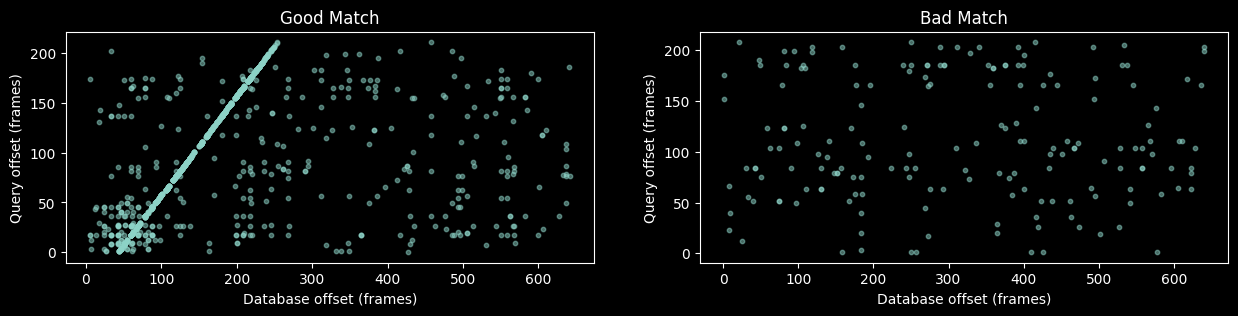

In [91]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Initialize the showcase database
showcase_db = defaultdict(list)
db_offsets_good = []
query_offsets_good = []
db_offsets_bad = []
query_offsets_bad = []

# Add tracks to the showcase database
for track_path in [f'tracks{os.path.sep}228.low.mp3', f'tracks/1420928.low.mp3']: # DoTo change these tracks
    for h, track_name, time_offset in compute_hashes_from_spectrogram(track_path):
        showcase_db[h].append((track_name, time_offset))

# Compute query constellation map and find the best match
query_name, query_cmap = compute_constellation_map_single((f'queries{os.path.sep}random_selection_short{os.path.sep}228_short.mp3', 4, 4))
best_track, best_delta, best_count, points = find_best_match_for_query(query_name, query_cmap, showcase_db)

# Process points to gather good and bad matches
for anchor in points:
    target_points = get_target_zone_points(
        anchor, points,
        time_min_offset=0, time_max_offset=25,
        freq_min_offset=-15, freq_max_offset=15
    )
    for target_point in target_points:
        h = compute_hash(anchor, target_point)
        if h in showcase_db:
            for (track_name, track_offset) in showcase_db[h]:
                if track_name == best_track:
                    db_offsets_good.append(track_offset)
                    query_offsets_good.append(anchor[1])
                else:
                    db_offsets_bad.append(track_offset)
                    query_offsets_bad.append(anchor[1])

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

# First subplot: Good matches
axes[0].scatter(db_offsets_good, query_offsets_good, alpha=0.5, s=10)
axes[0].set_xlabel("Database offset (frames)")
axes[0].set_ylabel("Query offset (frames)")
axes[0].set_title("Good Match")

# Second subplot: Bad matches
axes[1].scatter(db_offsets_bad, query_offsets_bad, alpha=0.5, s=10)
axes[1].set_xlabel("Database offset (frames)")
axes[1].set_ylabel("Query offset (frames)")
axes[1].set_title("Bad Match")

## Matching all queries with each configuration
size = XX tarballs - XXXXX tracks

In [92]:
s = time.time()
matches_1 = match_queries_with_chunks("queries", **config_1)
e = time.time()
print(e-s)

Query: queries/random_selection_compression/12828_10k_16k.mp3, Track ID: 12828, Match: True, Time: 38.6052131652832
Query: queries/random_selection_compression/14028_10k_16k.mp3, Track ID: 14028, Match: True, Time: 45.73988914489746
Query: queries/random_selection_compression/14728_10k_16k.mp3, Track ID: 14728, Match: True, Time: 29.635190963745117
Query: queries/random_selection_compression/15128_10k_16k.mp3, Track ID: 15128, Match: True, Time: 116.09554290771484
Query: queries/random_selection_compression/21628_10k_16k.mp3, Track ID: 21628, Match: True, Time: 32.067060470581055
Query: queries/random_selection_compression/22828_10k_16k.mp3, Track ID: 22828, Match: True, Time: 77.20708847045898
Query: queries/random_selection_compression/228_10k_16k.mp3, Track ID: 228, Match: True, Time: 28.33414077758789
Query: queries/random_selection_compression/24028_10k_16k.mp3, Track ID: 24028, Match: True, Time: 33.66565704345703
Query: queries/random_selection_compression/25228_10k_16k.mp3, Tra

In [93]:
s = time.time()
matches_2 = match_queries_with_chunks("queries", **config_2)
e = time.time()
print(e-s)

Query: queries/random_selection_compression/12828_10k_16k.mp3, Track ID: 12828, Match: True, Time: 25.037288665771484
Query: queries/random_selection_compression/14028_10k_16k.mp3, Track ID: 14028, Match: True, Time: 26.32880210876465
Query: queries/random_selection_compression/14728_10k_16k.mp3, Track ID: 14728, Match: True, Time: 17.72928237915039
Query: queries/random_selection_compression/15128_10k_16k.mp3, Track ID: 15128, Match: True, Time: 63.439130783081055
Query: queries/random_selection_compression/21628_10k_16k.mp3, Track ID: 21628, Match: True, Time: 19.359827041625977
Query: queries/random_selection_compression/22828_10k_16k.mp3, Track ID: 22828, Match: True, Time: 46.10872268676758
Query: queries/random_selection_compression/228_10k_16k.mp3, Track ID: 228, Match: True, Time: 18.83697509765625
Query: queries/random_selection_compression/24028_10k_16k.mp3, Track ID: 24028, Match: True, Time: 20.20573616027832
Query: queries/random_selection_compression/25228_10k_16k.mp3, Tr

In [94]:
s = time.time()
matches_3 = match_queries_with_chunks("queries", **config_3)
e = time.time()
print(e-s)

Query: queries/random_selection_compression/12828_10k_16k.mp3, Track ID: 12828, Match: True, Time: 25.15721321105957
Query: queries/random_selection_compression/14028_10k_16k.mp3, Track ID: 14028, Match: True, Time: 30.452966690063477
Query: queries/random_selection_compression/14728_10k_16k.mp3, Track ID: 14728, Match: True, Time: 20.41316032409668
Query: queries/random_selection_compression/15128_10k_16k.mp3, Track ID: 15128, Match: True, Time: 81.01940155029297
Query: queries/random_selection_compression/21628_10k_16k.mp3, Track ID: 21628, Match: True, Time: 23.3919620513916
Query: queries/random_selection_compression/22828_10k_16k.mp3, Track ID: 22828, Match: True, Time: 52.85477638244629
Query: queries/random_selection_compression/228_10k_16k.mp3, Track ID: 228, Match: True, Time: 21.551132202148438
Query: queries/random_selection_compression/24028_10k_16k.mp3, Track ID: 24028, Match: True, Time: 26.063203811645508
Query: queries/random_selection_compression/25228_10k_16k.mp3, Tra

In [95]:
s = time.time()
matches_4 = match_queries_with_chunks("queries", **config_4)
e = time.time()
print(e-s)

Query: queries/random_selection_compression/12828_10k_16k.mp3, Track ID: 12828, Match: True, Time: 37.57166862487793
Query: queries/random_selection_compression/14028_10k_16k.mp3, Track ID: 14028, Match: True, Time: 40.029287338256836
Query: queries/random_selection_compression/14728_10k_16k.mp3, Track ID: 14728, Match: True, Time: 27.295827865600586
Query: queries/random_selection_compression/15128_10k_16k.mp3, Track ID: 15128, Match: True, Time: 109.31134223937988
Query: queries/random_selection_compression/21628_10k_16k.mp3, Track ID: 21628, Match: True, Time: 35.02655029296875
Query: queries/random_selection_compression/22828_10k_16k.mp3, Track ID: 22828, Match: True, Time: 75.48069953918457
Query: queries/random_selection_compression/228_10k_16k.mp3, Track ID: 228, Match: True, Time: 33.15877914428711
Query: queries/random_selection_compression/24028_10k_16k.mp3, Track ID: 24028, Match: True, Time: 35.0499153137207
Query: queries/random_selection_compression/25228_10k_16k.mp3, Tra

# Task 4: Evaluation and Report

## Database build time

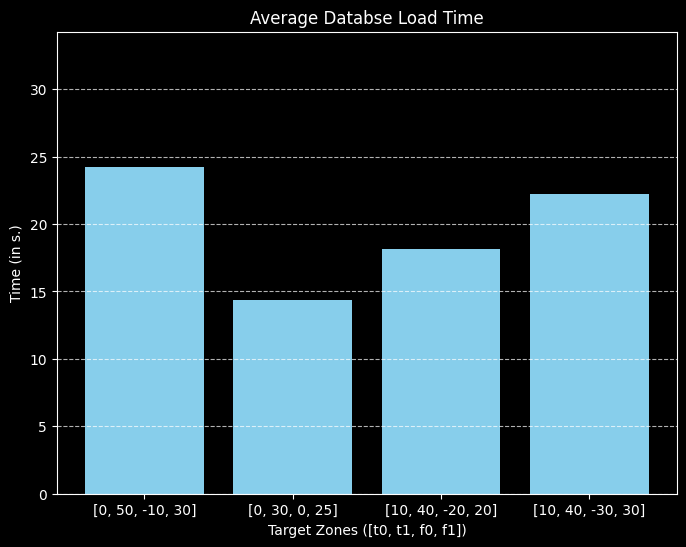

In [96]:
import matplotlib.pyplot as plt

# Values to plot
labels = [(f'[{config["time_min_offset"]}, {config["time_max_offset"]}, {config["freq_min_offset"]}, {config["freq_max_offset"]}]') for config in configs]

times = [0, 0, 0, 0]

times[0] += delta1
times[1] += delta2
times[2] += delta3
times[3] += delta4


# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, times, color='skyblue')
plt.title('Average Databse Load Time')
plt.xlabel('Target Zones ([t0, t1, f0, f1])')
plt.ylabel('Time (in s.)')
plt.ylim(0, max(times) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

## Query time comparison

In [97]:
# for evaluation
queries = load_filenames('queries')

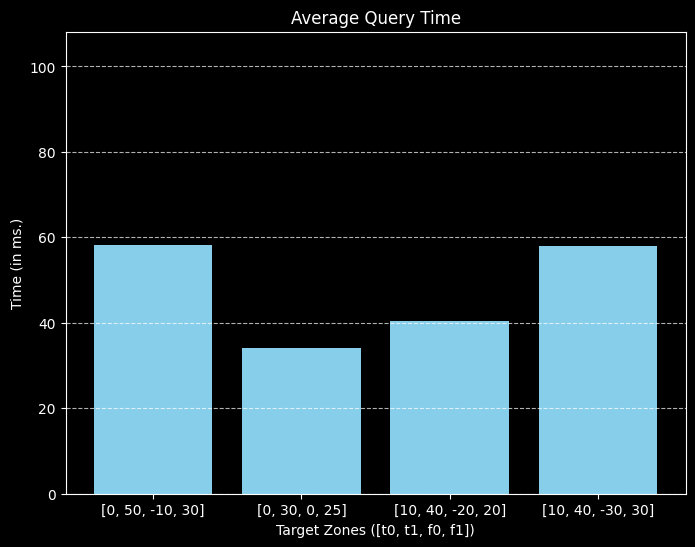

In [98]:
import matplotlib.pyplot as plt

# Values to plot
labels = [(f'[{config["time_min_offset"]}, {config["time_max_offset"]}, {config["freq_min_offset"]}, {config["freq_max_offset"]}]') for config in configs]

times = [0, 0, 0, 0]

for query_name in queries:
    times[0] += matches_1[query_name][4]
    times[1] += matches_2[query_name][4]
    times[2] += matches_3[query_name][4]
    times[3] += matches_4[query_name][4]

times[0] /= len(queries)
times[1] /= len(queries)
times[2] /= len(queries)
times[3] /= len(queries)


# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, times, color='skyblue')
plt.title('Average Query Time')
plt.xlabel('Target Zones ([t0, t1, f0, f1])')
plt.ylabel('Time (in ms.)')
plt.ylim(0, max(times) + 50)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

## Accuracy comparison

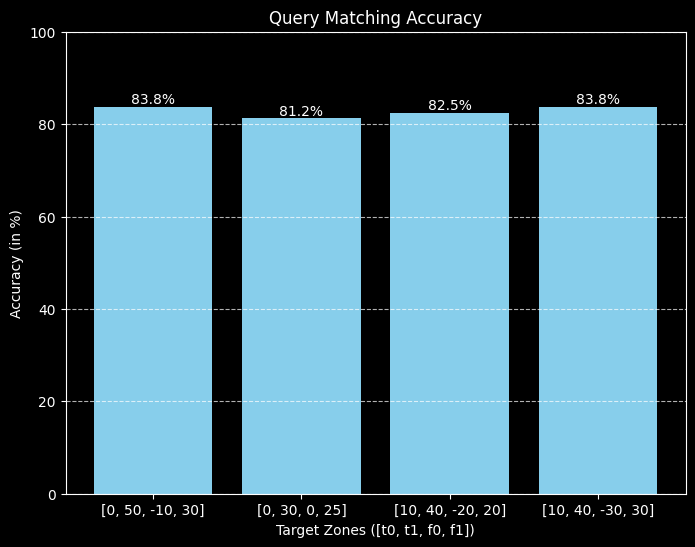

In [101]:
import matplotlib.pyplot as plt

get_accuracy(queries, matches_1)["total"]
accuracies = [get_accuracy(queries, matches_1)["total"], get_accuracy(queries, matches_2)["total"], get_accuracy(queries, matches_3)["total"], get_accuracy(queries, matches_4)["total"]]

# Values to plot
labels = [(f'[{config["time_min_offset"]}, {config["time_max_offset"]}, {config["freq_min_offset"]}, {config["freq_max_offset"]}]') for config in configs]
values = [ac*100 for ac in accuracies]


# Creating the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color='skyblue')

# Adding percentages above the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# Adding title and labels
plt.title('Query Matching Accuracy')
plt.xlabel('Target Zones ([t0, t1, f0, f1])')
plt.ylabel('Accuracy (in %)')
plt.ylim(0, 100)  # Leave some space above the bars for annotations
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

## Category Comparison

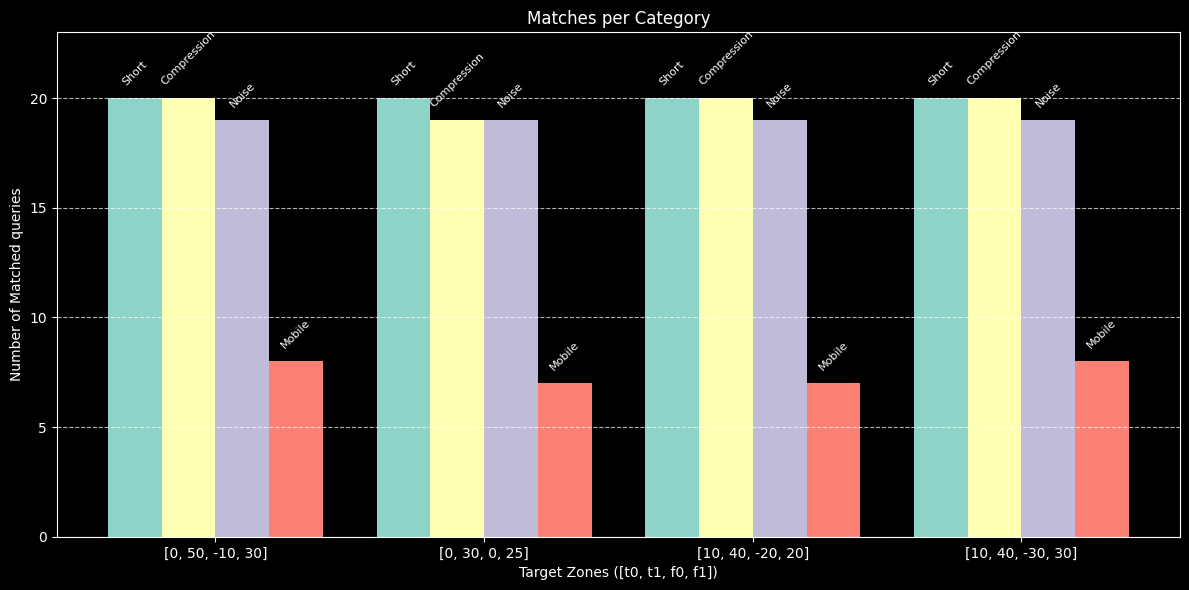

In [103]:
# Configuration names and corresponding counts for each category
labels = [(f'[{config["time_min_offset"]}, {config["time_max_offset"]}, {config["freq_min_offset"]}, {config["freq_max_offset"]}]') for config in configs]


matched_original = [get_accuracy(queries, matches_1)['short']*20, get_accuracy(queries, matches_2)['short']*20, get_accuracy(queries, matches_3)['short']*20, get_accuracy(queries, matches_4)['short']*20]
matched_noise = [get_accuracy(queries, matches_1)['noise']*20, get_accuracy(queries, matches_2)['noise']*20, get_accuracy(queries, matches_3)['noise']*20, get_accuracy(queries, matches_4)['noise']*20]
matched_coding = [get_accuracy(queries, matches_1)['compression']*20, get_accuracy(queries, matches_2)['compression']*20, get_accuracy(queries, matches_3)['compression']*20, get_accuracy(queries, matches_4)['compression']*20]
matched_mobile = [get_accuracy(queries, matches_1)['mobile']*20, get_accuracy(queries, matches_2)['mobile']*20, get_accuracy(queries, matches_3)['mobile']*20, get_accuracy(queries, matches_4)['mobile']*20]



# Number of configurations
num_configs = len(labels)

# X positions for groups of bars
x = np.arange(num_configs)

# Width of each bar
bar_width = 0.2

# Categories and their data
categories = ['Short', 'Compression', 'Noise', 'Mobile']
data = [matched_original, matched_coding, matched_noise, matched_mobile]

# Plot
plt.figure(figsize=(12, 6))

for i, category_data in enumerate(data):
    # Offset for each bar in a group
    bar_positions = x + (i - 1.5) * bar_width
    bars = plt.bar(bar_positions, category_data, width=bar_width)

    # Add category labels on top of each bar
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Adjusted offset for more space
                 categories[i], ha='center', va='bottom', rotation=45, fontsize=8)

# Add labels, title, and legend
plt.xlabel('Target Zones ([t0, t1, f0, f1])')
plt.ylabel('Number of Matched queries')
plt.title('Matches per Category')
plt.xticks(x, labels)

# Adjust the y-axis to leave more space at the top
plt.ylim(0, max(max(matched_original), max(matched_coding), max(matched_noise), max(matched_mobile)) + 3)

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Hash build comparison

In [104]:
import pandas as pd

dist_freq = 4
dist_time = 4
num_tracks = 34076

# Prepare data for the table
rows = []
for i, config in enumerate(configs):
    config_name = f'hash_count_freq4_time4_min{config["time_min_offset"]}_max{config["time_max_offset"]}_{config["freq_min_offset"]}_{config["freq_max_offset"]}'
    label = f"[{config['time_min_offset']}, {config['time_max_offset']}, {config['freq_min_offset']}, {config['freq_max_offset']}]"
    file_path = f"partial_database_{dist_freq}#{dist_time}#{config['time_min_offset']}#{config['time_max_offset']}#{config['freq_min_offset']}#{config['freq_max_offset']}.pkl"
    hash_value = hash_count.get(config_name, 0)

    # Get the file size in MB
    file_size_mb = os.path.getsize(file_path) / (1024 ** 2) if os.path.exists(file_path) else "File not found"

    # Calculate number of hashes per track
    hashes_per_track = hash_value / num_tracks if num_tracks > 0 else "N/A"

    rows.append({
        "Configuration": label,
        "Number of Hashes": hash_value,
        "Hashes per Track": round(hashes_per_track) if isinstance(hashes_per_track, (int, float)) else hashes_per_track,
        "Storage (MB)": round(file_size_mb, 2) if isinstance(file_size_mb, (int, float)) else file_size_mb
    })

# Create a DataFrame
hash_table = pd.DataFrame(rows)
hash_table.index = ["" for _ in range(len(hash_table))]  # Remove index

# Display the table
hash_table
#tabelle

,Configuration,Number of Hashes,Hashes per Track,Storage (MB)
,"[0, 50, -10, 30]",13300006,390,62.27
,"[0, 30, 0, 25]",5364906,157,25.74
,"[10, 40, -20, 20]",8389012,246,39.27
,"[10, 40, -30, 30]",11908046,349,57.47


## Avg. Hash Generation per track

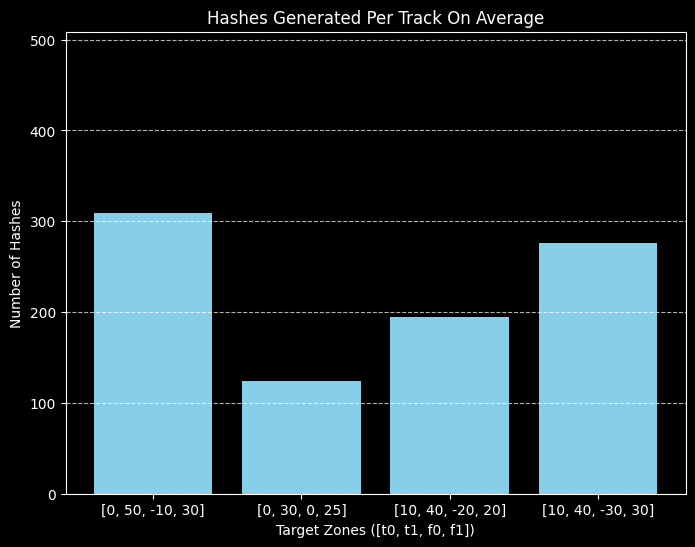

In [105]:
# Values to plot

config_names = [
    f'hash_count_freq4_time4_min{config["time_min_offset"]}_max{config["time_max_offset"]}_{config["freq_min_offset"]}_{config["freq_max_offset"]}'
    for config in configs
]

num_tracks = 43076

hashes = [0, 0, 0, 0]

hashes[0] += hash_count[config_names[0]]/num_tracks
hashes[1] += hash_count[config_names[1]]/num_tracks
hashes[2] += hash_count[config_names[2]]/num_tracks
hashes[3] += hash_count[config_names[3]]/num_tracks


# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, hashes, color='skyblue')
plt.title('Hashes Generated Per Track On Average')
plt.xlabel('Target Zones ([t0, t1, f0, f1])')
plt.ylabel('Number of Hashes')
plt.ylim(0, max(hashes) + 200)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()
#hashes pro tracks on average

# Thought process and Final Conclusion